<a href="https://colab.research.google.com/github/Aniket6334/Fake-News-Detector/blob/main/Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

About the Dataset:

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks whether the news article is real or fake:
           1: Fake news
           0: real News

**Import the dependencies**

In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**Data Pre-processing**

In [ ]:
# loading the dataset to a pandas dataframe
news_dataset = pd.read_csv('/content/train.csv',  encoding='latin1', low_memory = False)
# !ls /content

In [ ]:
news_dataset.shape

(25116, 686)

In [ ]:
# print the first 5 rows of the dataframe
news_dataset.head()

,id,title,author,text,label,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 676,Unnamed: 677,Unnamed: 678,Unnamed: 679,Unnamed: 680,Unnamed: 681,Unnamed: 682,Unnamed: 683,Unnamed: 684,Unnamed: 685
0,0,House Dem Aide: We Didnât Even See Comeyâs...,Darrell Lucus,House Dem Aide: We Didnât Even See Comeyâs...,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# counting the number of missing values in the dataset
news_dataset.isnull().sum()

,0
id,3
title,2250
author,4542
text,3079
label,3446
...,...
Unnamed: 681,25115
Unnamed: 682,25115
Unnamed: 683,25115
Unnamed: 684,25115


In [ ]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

In [ ]:
news_dataset.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0
...,...
Unnamed: 681,0
Unnamed: 682,0
Unnamed: 683,0
Unnamed: 684,0


In [ ]:
# @title Class distribution
print("Class Distribution:")
print(news_dataset['label'].value_counts())

Class Distribution:
label
1                                                                                                                                                                                                 10369
0                                                                                                                                                                                                 10349
                                                                                                                                                                                                   3446
 etc.                                                                                                                                                                                                 4
 Ð½Ð°Ð¿ÑÐ¸Ð¼ÐµÑ                                                                                                                                                             

In [ ]:
# merging the author and news title for better detection
news_dataset['content'] = news_dataset['author']+' '+ news_dataset['title']

In [ ]:
print(news_dataset['content'])

0        Darrell Lucus House Dem Aide: We Didnât Even...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
25111    Jerome Hudson Rapper T.I.: Trump a âPoster C...
25112    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
25113    Michael J. de la Merced and Rachel Abrams Macy...
25114    Alex Ansary NATO, Russia To Hold Parallel Exer...
25115              David Swanson What Keeps the F-35 Alive
Name: content, Length: 25116, dtype: object


In [ ]:
# separate the data & label column axis = 0 means removing row, 1 means column
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [ ]:
print(X)
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didnât Even See Comeyâs...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
25111  20795  Rapper T.I.: Trump a âPoster Child For White...   
25112  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
25113  20797  Macyâs Is Said to Receive Takeover Approach ...   
25114  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
25115  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

**Stemming:**
**Reducing a word to its root word**

In [ ]:
port_stem = PorterStemmer()

In [ ]:
# creating a function called stemming (33)
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ', content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [ ]:
news_dataset['content'] = news_dataset['content'].apply(stemming)

In [ ]:
print(news_dataset['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
25111    jerom hudson rapper trump poster child white s...
25112    benjamin hoffman n f l playoff schedul matchup...
25113    michael j de la merc rachel abram maci said re...
25114    alex ansari nato russia hold parallel exercis ...
25115                            david swanson keep f aliv
Name: content, Length: 25116, dtype: object


In [ ]:
# separating the data and label
X = news_dataset['content'].values
Y = news_dataset['label'].values

In [ ]:
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


In [ ]:
print(Y)

['1' '0' '1' ... '0' '1' '1']


In [ ]:
# @title TF - IDF
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [ ]:
print(X)

  (0, 294)	0.2711143595304882
  (0, 2676)	0.3695330951455916
  (0, 3190)	0.25021444167545076
  (0, 3884)	0.36190187718479516
  (0, 4092)	0.2719193039217898
  (0, 5380)	0.2242110980219714
  (0, 7617)	0.21896464665093704
  (0, 8387)	0.2514419730052186
  (0, 9387)	0.2931650914234994
  (0, 9694)	0.365543809573664
  (0, 14648)	0.24170537647240825
  (0, 17070)	0.2880854334390338
  (1, 1617)	0.28684095327432707
  (1, 2043)	0.16033000789330373
  (1, 2405)	0.3819555242659426
  (1, 3036)	0.19465794276348
  (1, 3850)	0.2655601620053947
  (1, 5954)	0.7141085899028713
  (1, 7407)	0.1937754459590677
  (1, 18279)	0.3003541536609626
  (2, 3174)	0.3289786239632894
  (2, 3349)	0.4735061475862881
  (2, 5829)	0.3938520403026429
  (2, 6467)	0.3373308801281171
  (2, 10451)	0.4757873319489284
  :	:
  (25113, 3932)	0.21371008348018833
  (25113, 7656)	0.2216005995344619
  (25113, 9104)	0.22557147358170038
  (25113, 9775)	0.3629705176720701
  (25113, 10332)	0.2978183783941726
  (25113, 10414)	0.1782507786420312

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

**Training the Model : Logistic Regression**

In [ ]:
model = LogisticRegression()

In [ ]:
model.fit(X_train, Y_train)

LogisticRegression()

In [ ]:
# @title Cross-Validation to verify accuracy
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.89723812 0.89674048 0.8939771  0.8989547  0.89323046]
Mean Accuracy: 0.8960281742856326


**Evaluation**

**Accuracy Score**

In [ ]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of the training data : ', training_data_accuracy*100, '%')

Accuracy score of the training data :  93.73880151304002 %


In [ ]:
# @title Analyze incorrect predictions
import pandas as pd
incorrect_preds = X_train[(X_train_prediction != Y_train)]
incorrect_df = pd.DataFrame({'Text': incorrect_preds, 'True Label': Y_train[(X_train_prediction != Y_train)],
                             'Predicted Label': X_train_prediction[(X_train_prediction != Y_train)]})
print("Misclassified Samples:")
incorrect_df.head()

Misclassified Samples:


,Text,True Label,Predicted Label
0,"(0, 2473)\t0.45427555660687385\n (0, 2563)\...",while the debtor will probably be bailed out ...,1
1,"(0, 2855)\t0.3275274782665145\n (0, 6467)\t...",dollar devaluation,1
2,,Ð½ÐµÐ»ÑÐ·Ñ,
3,"(0, 633)\t0.34154625698127783\n (0, 5982)\t...",,1
4,"(0, 7965)\t0.6603569877145642\n (0, 15340)\...",during his long career in Congress,1


In [ ]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score of the test data : ', test_data_accuracy*100, '%')

Accuracy score of the test data :  89.74920382165605 %


In [ ]:
# @title Analyze incorrect predictions
import pandas as pd
incorrect_preds = X_test[(X_test_prediction != Y_test)]
incorrect_df = pd.DataFrame({'Text': incorrect_preds, 'True Label': Y_test[(X_test_prediction != Y_test)],
                             'Predicted Label': X_test_prediction[(X_test_prediction != Y_test)]})
print("Misclassified Samples:")
incorrect_df

Misclassified Samples:


,Text,True Label,Predicted Label
0,"(0, 2110)\t0.2806088148112914\n (0, 4831)\t...",0,1
1,"(0, 16493)\t1.0",1,
2,"(0, 57)\t0.15699914644691526\n (0, 244)\t0....",,1
3,"(0, 432)\t0.12496684574456217\n (0, 844)\t0...",,1
4,"(0, 275)\t0.6344329118622775\n (0, 7899)\t0...",,1
...,...,...,...
510,"(0, 14749)\t0.910370255174105\n (0, 16937)\...",,1
511,"(0, 131)\t0.4256687726099307\n (0, 4493)\t0...",1,
512,"(0, 985)\t0.1721994147701283\n (0, 1943)\t0...",,1
513,"(0, 2363)\t0.40638427107916497\n (0, 6467)\...",,1


ValueError: The number of FixedLocator locations (186), usually from a call to set_ticks, does not match the number of labels (2).

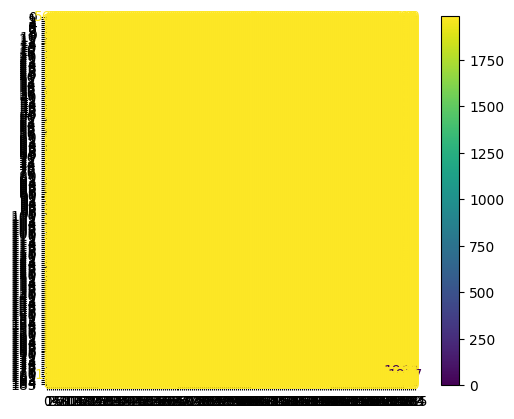

In [ ]:
# @title Confusion Matrix
cm = confusion_matrix(Y_test, X_test_prediction)
ConfusionMatrixDisplay(cm, display_labels=['Real', 'Fake']).plot()

**Making a predictive system**

In [ ]:
X_new = X_test[1234]

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

['1']
The news is Fake


In [ ]:
print(Y_test[1234])

1
